In [1]:
import os
import utils
import model_scoring
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"  # or choose another backend if you wish
import pandas as pd
from bokeh.plotting import figure, output_file, show
from bokeh.models import ColumnDataSource, DatetimeTickFormatter
from bokeh.models.tools import HoverTool
from bokeh.io.export import get_screenshot_as_png
from bokeh.io import output_notebook
import sklearn
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import datetime
import keras
from keras.models import Sequential, Model
from keras.layers import Embedding, Flatten, Dense, Dropout, Input, BatchNormalization

from sklearn.preprocessing import StandardScaler

Using plaidml.keras.backend backend.


In [2]:
output_notebook()

Loading BokehJS ...

In [3]:
train, test = utils.load_data(hourly=True)

Now, we will normalize the data.

In [4]:
# # scaler = StandardScaler()
# # train = scaler.fit_transform(train)
# # test = scaler.transform(test)

# # list(train.columns)

mean = train.mean(axis=0)
std = train.std(axis=0)

utils.preprocess(train, mean, std)
utils.preprocess(test, mean, std)

# train['target'] -= mean.target
# train['target'] /= std.target
# test['target'] -= mean.target
# test['target'] /= std.target


# # skip normalization and let batch normalization take over)
# utils.preprocess(train, normalize=False)
# utils.preprocess(test, normalize=False)

In [5]:
labels = train.pop('target')
train.head()

,temp,dwpt,heat_idx,rh,pressure,vis,wc,wdir,wspd,prcp,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
2009-05-10 10:00:00,0.254668,-0.179754,0.234085,-0.975517,-0.724918,0.360180,0.342674,1.036122,0.780809,-0.146297,...,0,0,1,0,0,0,0,0,0,0
2014-12-25 20:00:00,-0.474882,-0.603607,-0.478673,-0.535035,0.073934,0.360180,-0.500869,0.660871,0.422196,-0.146297,...,0,0,0,0,0,0,0,0,0,1
2011-10-20 03:00:00,0.591383,1.303734,0.563051,2.052795,-2.785114,-3.466023,0.623855,-0.277256,0.780809,-0.146297,...,0,0,0,0,0,0,0,1,0,0
2007-06-18 02:00:00,1.208695,1.091808,1.275809,-0.094554,-0.514694,0.360180,1.139354,1.317561,-1.012255,-0.146297,...,0,0,0,1,0,0,0,0,0,0
2008-05-12 17:00:00,-0.082048,-0.232735,-0.094880,-0.479975,-1.397635,0.360180,0.061493,-1.215384,2.573874,-0.146297,...,0,0,1,0,0,0,0,0,0,0


In [25]:
main_input = Input(shape=(train.shape[1],), name='main_input')
# x = BatchNormalization()(main_input)
x = Dense(128, activation='relu')(main_input)
# x = BatchNormalization()(x)
x = Dense(8, activation='relu')(x)

output = Dense(1, name='output')(x)

model = Model(inputs=[main_input], outputs=output)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      (None, 456)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               58496     
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1032      
_________________________________________________________________
output (Dense)               (None, 1)                 9         
Total params: 59,537
Trainable params: 59,537
Non-trainable params: 0
_________________________________________________________________


In [26]:
model.compile(optimizer='rmsprop',
              loss='mse',
              metrics=['mse'])
history = model.fit([train], labels,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2,
                   )

Train on 95077 samples, validate on 23770 samples
Epoch 1/10
95077/95077 [==============================] - 13s 136us/step - loss: 0.0925 - mean_squared_error: 0.0925 - val_loss: 0.0643 - val_mean_squared_error: 0.0643
Epoch 2/10
95077/95077 [==============================] - 12s 123us/step - loss: 0.0476 - mean_squared_error: 0.0476 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 3/10
95077/95077 [==============================] - 12s 121us/step - loss: 0.0388 - mean_squared_error: 0.0388 - val_loss: 0.0424 - val_mean_squared_error: 0.0424
Epoch 4/10
95077/95077 [==============================] - 11s 121us/step - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss: 0.0481 - val_mean_squared_error: 0.0481
Epoch 5/10
95077/95077 [==============================] - 12s 121us/step - loss: 0.0301 - mean_squared_error: 0.0301 - val_loss: 0.0429 - val_mean_squared_error: 0.0429
Epoch 6/10
95077/95077 [==============================] - 12s 124us/step - loss: 0.0275 - mean_squared_er

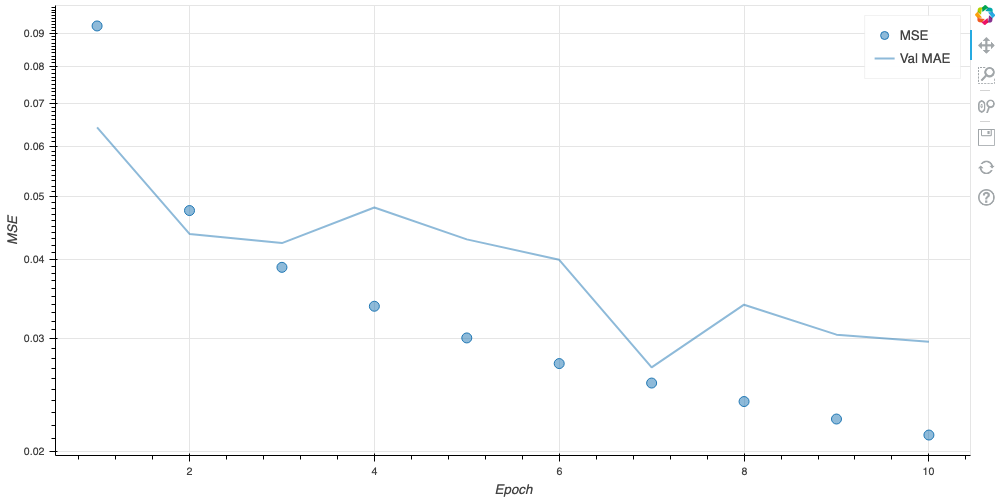

In [27]:
source = pd.DataFrame(history.history)
source['epoch'] = source.index + 1
acc_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='MSE', y_axis_type='log')
acc_plot.circle(x='epoch', y='mean_squared_error', source=source, size=10, fill_alpha=.5, legend_label='MSE')
acc_plot.line(x='epoch', y='val_mean_squared_error', source=source, line_width=2, legend_label='Val MAE', alpha=0.5)
# show(acc_plot)
get_screenshot_as_png(acc_plot, driver=None)

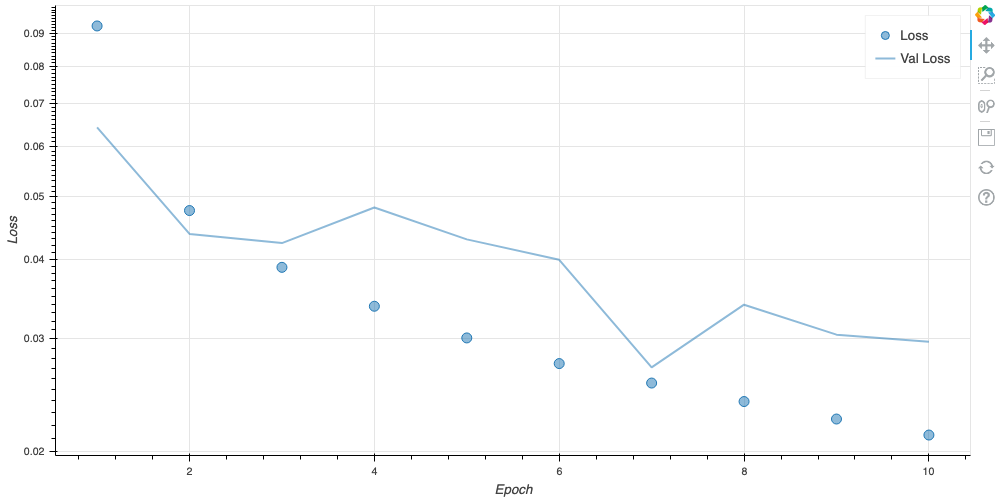

In [28]:
loss_plot = figure(plot_width=1000, plot_height=500, x_axis_label='Epoch', y_axis_label='Loss', y_axis_type='log')
loss_plot.circle(x='epoch', y='loss', source=source, size=10, fill_alpha=.5, legend_label='Loss')
loss_plot.line(x='epoch', y='val_loss', source=source, line_width=2, legend_label='Val Loss', alpha=0.5)
# show(loss_plot)
get_screenshot_as_png(loss_plot, driver=None)

Previously achieved with NOAA weather data:  
  
Total prediction error: 113288.0  
Total ISOLF prediction error: 63146.0  
Percentage of time the model outperformed the NYISO model: 31.76 (175/551)  
  
  
Hourly results from before:  
  
Total prediction error: 2139681.0
Total ISOLF prediction error: 2174812.0
Percentage of time the model outperformed the NYISO model: 46.51 (6142/13205)

In [29]:
predictions = model.predict(test.copy().drop(columns=['target']))
isolf = utils.isolf_hourly(lookahead=1)
results = test.copy()
results['prediction'] = predictions
results = results.join(isolf, how='inner')
results['target'] *= std.target
results['target'] += mean.target
results['prediction'] *= std.target
results['prediction'] += mean.target
results['date'] = results.index
results = results.astype({'prediction': 'float'})

results, pred_plot = model_scoring.eval(results)

Total prediction error: 2139681.0
Total ISOLF prediction error: 2174812.0
Percentage of time the model outperformed the NYISO model: 46.51 (6142/13205)


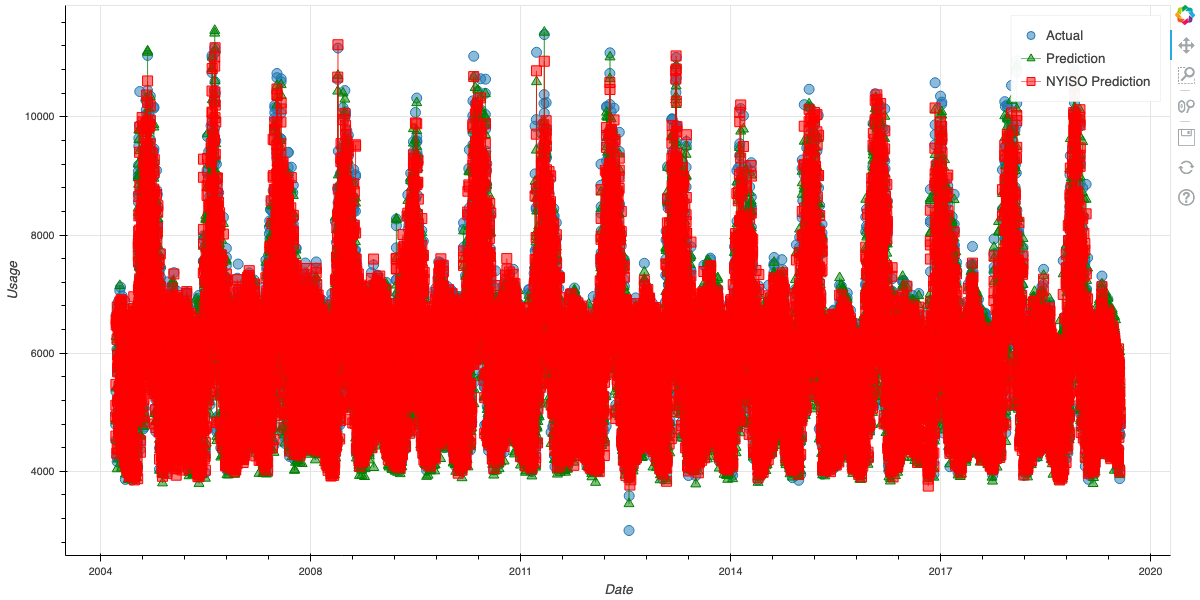

In [30]:
# show(pred_plot)
get_screenshot_as_png(pred_plot, driver=None)

In [12]:
results

,target,temp,dwpt,heat_idx,rh,pressure,vis,wc,wdir,wspd,...,month_8,month_9,month_10,month_11,month_12,prediction,nyiso_prediction,date,prediction_error,nyiso_prediction_error
2012-07-02 10:00:00,9097.633,1.377052,0.826899,1.330637,-0.865397,-0.472649,0.36018,1.279944,1.317561,0.242890,...,0,0,0,0,0,5835.020020,8674,2012-07-02 10:00:00,-3262.612980,-423.633
2018-07-03 21:00:00,8771.333,1.433172,1.568643,1.604774,0.511109,0.788696,0.36018,1.326808,-0.089631,-0.832949,...,0,0,0,0,0,5642.654785,8919,2018-07-03 21:00:00,-3128.678215,147.667
2017-06-13 21:00:00,9700.550,1.657648,1.356716,1.769257,-0.369855,-0.766963,0.36018,1.514262,-1.684448,0.422196,...,0,0,0,0,0,6748.689941,8877,2017-06-13 21:00:00,-2951.860059,-823.550
2017-07-03 15:00:00,8873.467,1.769887,1.038826,1.714430,-1.085637,-0.304469,0.36018,1.607989,0.942310,0.601503,...,0,0,0,0,0,5957.437500,8649,2017-07-03 15:00:00,-2916.029500,-224.467
2014-07-03 11:00:00,9348.383,1.433172,1.568643,1.604774,0.511109,-0.220380,0.36018,1.326808,-1.496822,-1.370868,...,0,0,0,0,0,6484.817383,9918,2014-07-03 11:00:00,-2863.565617,569.617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2006-01-07 03:00:00,4548.167,-1.653386,-1.504297,-1.630052,-0.204674,-0.514694,0.36018,-1.859910,1.036122,1.139422,...,0,0,0,0,0,5939.514648,4390,2006-01-07 03:00:00,1391.347648,-158.167
2007-01-07 13:00:00,5315.683,-0.418763,-0.974479,-0.423846,-1.305878,1.125054,0.36018,-0.219688,-1.590635,-1.908788,...,0,0,0,0,0,6776.564453,5268,2007-01-07 13:00:00,1460.881453,-47.683
2016-06-19 06:00:00,4848.858,0.759741,0.614972,0.727533,-0.259734,1.125054,0.36018,0.764446,0.191808,-0.653642,...,0,0,0,0,0,6408.838379,4787,2016-06-19 06:00:00,1559.980379,-61.858
2012-01-07 18:00:00,5899.708,0.086310,-0.338699,0.069603,-0.975517,-0.893097,0.36018,0.202084,0.567059,0.780809,...,0,0,0,0,0,7504.170898,5990,2012-01-07 18:00:00,1604.462898,90.292
